Imports and General Setup

In [1]:


# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import logging
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
import json

# MNE library for EEG data analysis
import mne
from mne import Epochs,find_events
from mne.decoding import Vectorizer
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA

from autoreject import AutoReject

# XDF file format support in MNE
import pyxdf
from mne_import_xdf import *

# Scikit-learn and Pyriemann for feature extraction and machine learning functionalities
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score,train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

#import moab to get the filterbank implementation: 
from moabb.pipelines.utils import FilterBank

# For  GUI elements
from easygui import *

# For path manipulation
import pathlib
from os import listdir
from os.path import isfile, join

# For interactive plots
import PyQt5
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')

#imports for precision_recall_curve related plot: 
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve,PrecisionRecallDisplay
from itertools import cycle
import matplotlib.pyplot as plt
import pickle

import copy


from braindecode.models import ShallowFBCSPNet
from braindecode.datautil import create_from_mne_epochs
from braindecode.training import CroppedLoss
from braindecode.training.scoring import trial_preds_from_window_preds
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch


from preprocessing import *
from training import *
from evaluation import *

# Define paths for data storage and processing
current_path = pathlib.Path().absolute()  
recording_path = current_path / 'Recordings'
figure_outputs_path=current_path / 'Figures'

#extract all recorded files and subject names
recording_files = [f for f in listdir(recording_path) if isfile(join(recording_path, f)) and ('.xdf' in f)]
if not(figure_outputs_path.exists()):
    print('the output folder does not exists:  ',figure_outputs_path)


print('all available recording files',recording_files)
subject_names=[r.split('_')[0] for r in recording_files]
print('only subjects IDS:',subject_names)

# Initial definitions: 

print('filenames:\n',recording_files)
print('names:\n',subject_names)


#define the electrode groups: the key can be anything, the values should be a list of electrodes
Electorde_Groups = {'FP': ['Fp1', 'Fp2'],
                   'AF': ['AF7', 'AF3', 'AFz', 'AF4', 'AF8'],
                   'F' : ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
                   'FC': ['FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6'],
                   'C' : ['C5', 'C3', 'C1', 'Cz', 'C2', 'C4' ,'C6'],
                   'CP': ['CP5', 'CP3','CP1', 'CPz', 'CP2', 'CP4', 'CP6'],
                   'P' : ['P7','P5','P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
                   'PO': ['PO7','PO3', 'POz', 'PO4', 'PO8'],
                   'O' : ['Oz', 'O2', 'O1', 'Iz']
                  } 

all available recording files ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'g_mi_1.xdf', 'g_mi_3.xdf', 'g_mi_4.xdf']
only subjects IDS: ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'g', 'g', 'g']
filenames:
 ['Fudge_MI3_1.xdf', 'Fudge_MI3_2.xdf', 'Fudge_MI3_3.xdf', 'Fudge_MI3_4.xdf', 'g_mi_1.xdf', 'g_mi_3.xdf', 'g_mi_4.xdf']
names:
 ['Fudge', 'Fudge', 'Fudge', 'Fudge', 'g', 'g', 'g']


Create a parameter dictionary 

In [26]:
params_dict={}
params_dict['PerformCsd']=True
Electorde_Group_Names='F+FC+C+CP+P'
params_dict['Electorde_Group']=[] 
for cur_elec_group_name in Electorde_Group_Names.split('+'):
    params_dict['Electorde_Group']=params_dict['Electorde_Group']+Electorde_Groups[cur_elec_group_name]
params_dict['bad_electrodes'] = get_subject_bad_electrodes ('g') # Manually define subject name
params_dict['filter_method']='fir'
params_dict['epoch_tmins_and_maxes_grid'] = [-4,6]
params_dict['epoch_tmin'] = -4
params_dict['epoch_tmax'] = 6
params_dict['n_components']= 10
params_dict['LowPass']=5
params_dict['HighPass']=35
params_dict['filters_bands']=[[7, 12], [12, 20], [20, 28], [28, 35]]
params_dict['augmentation_params']={'win_len': 1, 'win_step': 0.1}
params_dict['classifier_window_s']=1
params_dict['classifier_window_e']=3
params_dict['windowed_prediction_params']={'win_len': 2, 'win_step': 0.1}
params_dict['pipeline_name']='csp+lda'
params_dict['n_components_fbcsp']=10
params_dict['desired_events'] = ['ActiveRest','OpenPalm'] 


Load XDF files and convert to combined mne Raw instance

In [27]:
xdf_files = [f for f in recording_path.glob('*.xdf') if 'g_mi' in  f.name] # fill in name to select subject files
#OriginalRaw = Load_and_concatenate_xdf(xdf_files)

In [28]:
epochs_list = []
filter_bank_epochs_list = []
for xdf_file in xdf_files:
    raw=read_raw_xdf(xdf_file)
    epoch,filter_bank_epochs,mean_across_epochs, events_trigger_dict = EEG_Preprocessing(current_path,raw,params_dict)
    epochs_list.append(epoch)
    filter_bank_epochs_list.append(filter_bank_epochs)

print("Concatenating all preprocessed epochs...")
epochs = mne.concatenate_epochs(epochs_list, on_mismatch='warn')
filter_bank_epochs = None

Creating RawArray with float64 data, n_channels=67, n_times=329760
    Range : 0 ... 329759 =      0.000 ...   659.518 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 5001 original time points ...
1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.4s finished


ActiveRest
OpenPalm
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=303269
    Range : 0 ... 303268 =      0.000 ...   606.536 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 32 events and 5001 original time points ...
0 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.3s finished


ActiveRest
OpenPalm
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Creating RawArray with float64 data, n_channels=67, n_times=359073
    Range : 0 ... 359072 =      0.000 ...   718.144 secs
Ready.

###########################################################
removing subject specific bad electrodes from the raw data

###########################################################
removing bad channels from epochs:
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
not using csd
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.

###########################################################
filtering the data
Filtering raw data in 1 contiguous segment
Setting up 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['ActiveRest', 'Beep', 'ClosePalm', 'Long Break', 'OpenPalm', 'Rest']

###########################################################
extracting event info: {'ActiveRest': 1, 'Beep': 2, 'ClosePalm': 3, 'Long Break': 4, 'OpenPalm': 5, 'Rest': 6}

###########################################################
epoching + selecting current electodes set for analysis:
['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8']
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 39 events and 5001 original time points ...
0 bad epochs dropped
Fitted sphere radius:         95.0 mm


[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.4s finished


Origin head coordinates:      0.0 -0.0 0.0 mm
Origin device coordinates:    0.0 -0.0 0.0 mm
ActiveRest
OpenPalm
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated

###########################################################
removing bad channels from epochs:
Concatenating all preprocessed epochs...
Not setting metadata
103 matching events found
No baseline correction applied


Pre-processing

In [29]:
events = epochs.events
event_dict = epochs.event_id
params_dict['events_trigger_dict'] = {key: event_dict[key] for key in event_dict.keys() if key in params_dict['desired_events']}
train_inds,validation_inds,return_dict = Split_training_validation (epochs,filter_bank_epochs, params_dict['events_trigger_dict'])
epochs_copy = epochs.copy()
returned_dict=crop_the_data(epochs_copy,train_inds,validation_inds,params_dict['classifier_window_s'],params_dict['classifier_window_e']) #two more paramters here are tmin and tmax which are not used apparently. 
train_set_data_uncropped=returned_dict['train_set_data_uncropped']
epochs_cropped=returned_dict['epochs_cropped']
train_set_data=returned_dict['train_set_data']
train_set_labels=returned_dict['train_set_labels']

validation_set_labels=returned_dict['validation_set_labels']
validation_set_data_uncropped=returned_dict['validation_set_data_uncropped']
#define cv on the data: 
cv = StratifiedShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(train_set_data,train_set_labels)

#filter bank related:
if params_dict['pipeline_name']=='fbcsp+lda': 
    train_set_data_fb=[]
    train_set_data_uncropped_fb=[]
    validation_set_data_fb=[]
    validation_set_data_uncropped_fb=[]
    for filtered_data_band_epoch in preprocessing_dict['filter_bank_epochs']:
        returned_dict_temp=crop_the_data(filtered_data_band_epoch,train_inds,validation_inds, params_dict['classifier_window_s'],params_dict['classifier_window_e'])
        #extract the train set data: 
        train_set_data_uncropped_temp=returned_dict_temp['train_set_data_uncropped']
        train_set_data_temp=returned_dict_temp['train_set_data']
        train_set_data_fb.append(train_set_data_temp)
        train_set_data_uncropped_fb.append(train_set_data_uncropped_temp)
        #extract the validation set data: 
        validation_set_data_uncroped_temp=returned_dict_temp['validation_set_data_uncroped']
        validation_set_data_temp=returned_dict_temp['validation_set_data']
        validation_set_data_fb.append(validation_set_data_temp)
        validation_set_data_uncropped_fb.append(validation_set_data_uncroped_temp)
    #create a 4d matrix of train data:     
    train_set_data_4d_array= np.transpose(np.array(train_set_data_fb),(1,2,3,0))
    train_set_data_uncropped_4d_array=np.transpose(np.array(train_set_data_uncropped_fb),(1,2,3,0)) 
    train_set_data=train_set_data_4d_array
    train_set_data_uncropped=train_set_data_uncropped_4d_array
    #create a 4d matrix of validation data: 
    validation_set_data_4d_array= np.transpose(np.array(validation_set_data_fb),(1,2,3,0))
    validation_set_data_uncropped_4d_array=np.transpose(np.array(validation_set_data_uncropped_fb),(1,2,3,0)) 
    validation_set_data_uncropped=validation_set_data_uncropped_4d_array


augmented_x,augmented_y = augment_data(params_dict['augmentation_params'], train_set_data,train_set_labels,epochs.info['sfreq'])

triggers_label_dict={val:key for key,val in params_dict['events_trigger_dict'].items()} 
test_data_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in validation_set_labels])  
augmented_y_labels=np.array([triggers_label_dict[cur_y] for cur_y in augmented_y])  


putting aside 20% of the data: trial numbers are:
 [ 46  89  75  95  68  11 101  58   8  72  26  30  18  48  17  45  50  81
  32  36  14]

remaining 80% of the trials go into training for cv:
 [102  19  47   5  94  52  76  51  71  56  91  65  22  64  35  61  87  42
  69  21  28  23  29  93  97  43  63  31  84  66  78  62  79  13  16  86
  40  41  49  85  88  34  98  27  57  24  67 100   6  96  77  99   1  92
   4  20  70  37  38  54  10  83  90   7   9  44   2  12   3  25  33  59
  82  73  15  74  55  39   0  80  53  60]



Cross-Validation Evaluation 

In [30]:
scores_windows,folds_confusion_matrices_per_window,w_times= run_windowed_classification_aug_cv(epochs, returned_dict['epochs_cropped'], cv_split,params_dict)

Computing rank from data with rank=None
    Using tolerance 0.072 (2.2e-16 eps * 36 dim * 9e+12  max singular value)
    Estimated rank (mag): 36
    MAG: rank 36 computed from 36 data channels with 0 projectors
Reducing data rank from 36 -> 36
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.064 (2.2e-16 eps * 36 dim * 8e+12  max singular value)
    Estimated rank (mag): 36
    MAG: rank 36 computed from 36 data channels with 0 projectors
Reducing data rank from 36 -> 36
Estimating covariance using OAS
Done.
Class order in confusion matrix: ['ActiveRest' 'OpenPalm']
Computing rank from data with rank=None
    Using tolerance 0.072 (2.2e-16 eps * 36 dim * 9e+12  max singular value)
    Estimated rank (mag): 36
    MAG: rank 36 computed from 36 data channels with 0 projectors
Reducing data rank from 36 -> 36
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.063 (2.2e-16 eps * 36 dim * 7.

In [31]:
plot_accuracy_over_time(scores_windows, w_times, params_dict, axes_handle=None)

In [32]:
w_step = int(500 * 0.1)   # running classifier: window length
w_length = int(500 * 2)
w_start = np.arange(0, epochs.get_data().shape[2] - w_length, w_step)

In [20]:
    w_times = (w_start + w_length / 2.) / 500 + params_dict['epoch_tmin']


In [22]:
w_start

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
       1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150,
       2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700,
       2750, 2800, 2850, 2900, 2950, 3000])

Training

In [ ]:
clf,csp,lda = classifier_training(augmented_x,augmented_y,params_dict, BinaryClassification = False)

Computing rank from data with rank=None
    Using tolerance 0.077 (2.2e-16 eps * 36 dim * 9.7e+12  max singular value)
    Estimated rank (mag): 36
    MAG: rank 36 computed from 36 data channels with 0 projectors
Reducing data rank from 36 -> 36
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.067 (2.2e-16 eps * 36 dim * 8.4e+12  max singular value)
    Estimated rank (mag): 36
    MAG: rank 36 computed from 36 data channels with 0 projectors
Reducing data rank from 36 -> 36
Estimating covariance using OAS
Done.


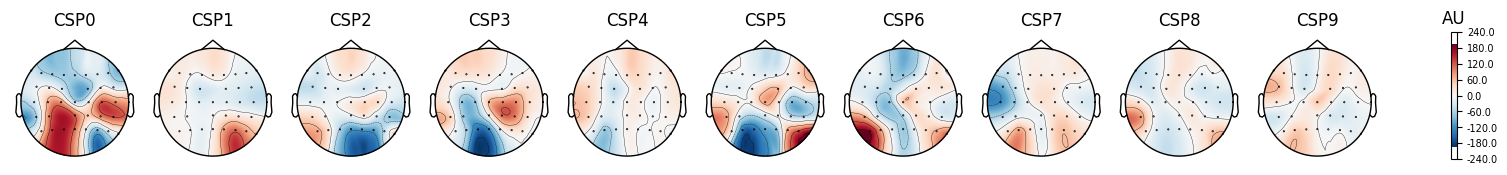

In [86]:
csp.plot_patterns(epochs.info)

In [87]:
w_length = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_len'])   # running classifier: window length
w_step = int(raw.info['sfreq'] * params_dict['windowed_prediction_params']['win_step'])  # running classifier: window step size
w_start = np.arange(0, train_set_data_uncropped.shape[2] - w_length, w_step)
w_times = (w_start + w_length / 2.) / raw.info['sfreq'] + params_dict['epoch_tmin']

In [88]:
scores_per_time_window,confusion_matrices_per_window = run_windowed_pretrained_classifier(clf,validation_set_data_uncropped,test_data_y_labels,w_start,w_length)


Class order in confusion matrix: ['ActiveRest' 'ClosePalm']


In [ ]:
scores_per_time_window

In [89]:
plot_accuracy_over_time(scores_per_time_window, w_times, params_dict, axes_handle=None)

IndexError: tuple index out of range

In [38]:
train_set_data_uncropped.shape[2] + 500- w_length

3501

In [22]:
scores_windows_array = np.squeeze(np.array(scores_per_time_window))

In [23]:
scores_windows_array.shape

(71,)

In [ ]:
confusion_matrices_per_window

[(array([[2, 9],
         [1, 9]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[2, 9],
         [2, 8]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[3, 8],
         [2, 8]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[5, 6],
         [4, 6]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[6, 5],
         [4, 6]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[7, 4],
         [5, 5]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[7, 4],
         [4, 6]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[7, 4],
         [7, 3]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[7, 4],
         [6, 4]], dtype=int64),
  array(['ActiveRest', 'ClosePalm'], dtype='<U10')),
 (array([[7, 4],
         [5, 5]], dtype=int64),
  array(['ActiveRest', 'ClosePalm

In [91]:

# Example: Plot confusion matrix for the first time window
conf_matrix, class_labels = confusion_matrices_per_window[50]
plot_confusion_matrix(conf_matrix, class_labels)

In [92]:
scores_per_time_window

[0.5238095238095238,
 0.47619047619047616,
 0.5238095238095238,
 0.5238095238095238,
 0.5714285714285714,
 0.5714285714285714,
 0.6190476190476191,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.38095238095238093,
 0.42857142857142855,
 0.47619047619047616,
 0.5238095238095238,
 0.5714285714285714,
 0.5238095238095238,
 0.47619047619047616,
 0.47619047619047616,
 0.5238095238095238,
 0.6190476190476191,
 0.5238095238095238,
 0.6190476190476191,
 0.6666666666666666,
 0.6190476190476191,
 0.7142857142857143,
 0.6666666666666666,
 0.6666666666666666,
 0.8095238095238095,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7619047619047619,
 0.7142857142857143,
 0.7619047619047619,
 0.7619047619047619,
 0.8095238095238095,
 0.8571428571428571,
 0.8571428571428571,
 0.8571428571428571,
 0.9047619047619048,
 0.8571428571428571,
 0.7619047619047619,
 0.8571428571428571,
 0.7619047619047619,
 0.7142857142857143,
 0.66

In [52]:
scores_per_time_window


[0.3142857142857143,
 0.37142857142857144,
 0.34285714285714286,
 0.3142857142857143,
 0.34285714285714286,
 0.34285714285714286,
 0.4,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.42857142857142855,
 0.4,
 0.42857142857142855,
 0.4,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.42857142857142855,
 0.42857142857142855,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.4857142857142857,
 0.4857142857142857,
 0.45714285714285713,
 0.42857142857142855,
 0.45714285714285713,
 0.5142857142857142,
 0.6,
 0.5714285714285714,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.5714285714285714,
 0.6,
 0.5714285714285714,
 0.5714285714285714,
 0.5428571428571428,
 0.5428571428571428,
 0.5428571428571428,
 0.5142857142857142,
 0.5428571428571428,
 0.5142857142857142,
 0.45714285714285713,
 0.45714285714285713,
 0.45714285714285713,
 0.42857142857142855,
 0.485

In [93]:
def average_from_index_to_index(lst, start, end):
    # Ensure the indices are within the bounds of the list
    if start < 0 or end >= len(lst) or start > end:
        raise ValueError("Invalid start or end index")
    
    # Slice the list from start to end (inclusive)
    sublist = lst[start:end+1]
    
    # Calculate the average
    average = sum(sublist) / len(sublist)
    
    return average

# Example usage
start_index = 20
end_index =70
print(average_from_index_to_index(scores_per_time_window, start_index, end_index))  # Output: 35.0

0.7292250233426708


In [79]:
# Time points (assuming each point is 100 ms apart)
time_points = np.arange(0, len(scores_per_time_window) * 0.1, 0.1)  # in seconds

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_points, scores_per_time_window, marker='o')
plt.title('Sliding Window Scores Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

In [246]:
all_epoch_data = epochs.get_data()

In [247]:

scaler = RobustScaler()
all_epoch_data_flat = all_epoch_data.reshape(all_epoch_data.shape[0], -1)
all_epoch_data_normalized = scaler.fit_transform(all_epoch_data_flat).reshape(all_epoch_data.shape)

# Update combined epochs with normalized data
epochs._data = all_epoch_data_normalized

In [22]:
from sklearn.preprocessing import StandardScaler, RobustScaler


In [29]:
loaded_epochs = mne.read_epochs('epochs_combined-epo2.fif', preload=True)

Reading c:\Users\gilad\3_Class_MI_21_01_25\epochs_combined-epo2.fif ...
    Found the data of interest:
        t =   -3000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
